# Model Notebook
Feature Engineering:
 - Datetime extraction
 - Introduce Phases
 - Use predicted average daily temperature to help fit model.

I have decided to implement 3 different models. The model that returns the best rmse gets to predict future.
1. SARIMAX
2. FBProphet
3. LightGBM

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

### Data Preprocessing
The original dataset can be found from data.ny.gov and time ranges from 2010-2020. <br>
https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga <br>
The counts are in hourly form and need to be resampled to Daily.
In addition, the bridges('plaza_id') are coded numerically and need to be renamed. <br>
Please note: I have combined Triboro Manhattan and Triboro Bronx into Triboro.

On 2017, NYC finished installing cashless tolls. I will, therefore, use data from 2018 and on because data was collected differently prior to 2017.

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [3]:
df = return_series('mta.csv')

### 9 Toll Bridges in NYC

There are some days when there were 0 crossings over bridges. (missing values). <br> For this project, I have decided to fill the missing values with the previous day count. <br>





In [4]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

### Feature Engineering: Holidays
Holidays will be an important feature in determining daily toll traffic. I created a list of all the holidays from 2018-2021.

In [5]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020, 2021]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']

### Feature Engineering: Date Features
From datetime, I extract the month, day of the week, year, weekend... etc. <br> In addition, I have included the 8 events that occurred in **2020**
0. March 12 - Events with more than 500 people cancelled
1. March 22 - NYS Pause Program begins, all non-essential workers must stay home
2. April 16 - Governor Cuomo extendes the stay-at-home order and school closures to May 15
3. May 15 - Governor Cuomo extends PAUSE to May 28
4. June 8 - NYC begins Phase 1 opening
5. June 22 - NYC begins Phase 2 opening
6. July 7 - NYC begins Phase 3 opening
7. July 19 - NYC begins Phase 4 opening

The timeline was extracted from investopedia. <br>
https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [6]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [7]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(1000, 19)


plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286,1,0,2018,1,1,1,1,-1,0,1
2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211,1,1,2018,1,2,1,2,-1,0,0
2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974,1,2,2018,1,3,1,3,-1,0,0
2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114,1,3,2018,1,4,1,4,-1,0,0
2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229,1,4,2018,1,5,1,5,-1,0,0


### Feature Engineer: Average Daily Temperatures
I will predict the average daily temperature from 2018 to current and use the y_hat values as a feature. The temperature data will train from 2010 to 2018.

The dataset comes from https://w2.weather.gov/climate/xmacis.php?wfo=okx with JFK, NY selected.
It ranges from 2010-2020. I will be only taking temp_average of each day.
The dataset will be made applicable via kaggle.


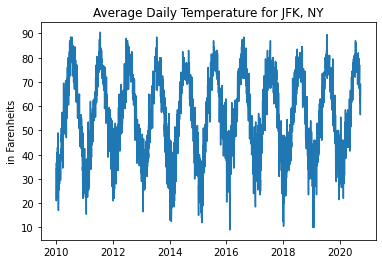

In [8]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

I'll do a quick forecasting on average daily temperature using FBProphet. <br>
Training set was 2010-2017, Testing set: 2018-2020

In [9]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [10]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [11]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

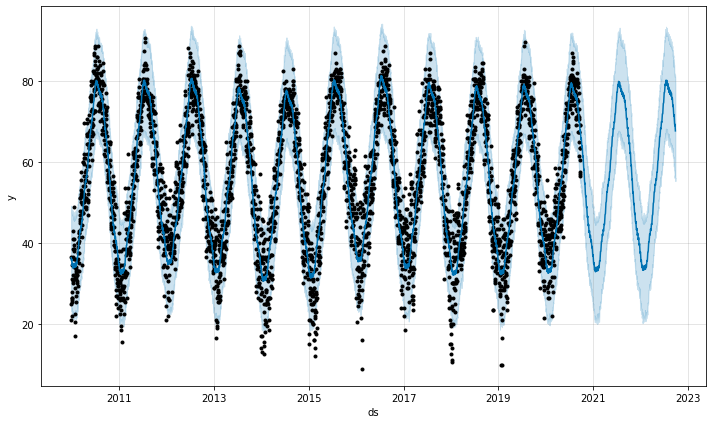

In [12]:
fig1 = m.plot(forecast)

In [13]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2018-01-01', end='2020-09-26'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [14]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.head()

,temp_average
datetime,
2018-01-01,34.744700
2018-01-02,35.134029
2018-01-03,34.775099
2018-01-04,34.159110
2018-01-05,33.598794


In [15]:
_df['temp_average'] = sliced_forecast['temp_average']

## Models

### Dummy Regressor
My baseline will be the average of the last 7 days for each bridge.
The sum of the 9 rmse (for each bridge) will be my metric.
I have chosen to use root mean squared error because it is more sensitive to larger errors than MAE(mean absolute error) or MAPE(mean absolute percentage error)

In [16]:
dummy_MA7 = []
for bridge in bridges:
    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-26'
    tes = _df[te_start:te_end][bridge]
    tra = _df[tr_start:tr_end][bridge]
    _dummy = pd.DataFrame()
    _dummy['datetime'] = pd.date_range(start='2020-08-23', end='2020-09-26')
    _dummy.set_index('datetime', inplace=True)
    _dummy[bridge] = tra.tail(7).mean()
    
    dummy_MA7.append(np.sqrt(mean_squared_error(tes,_dummy)))
    

In [17]:
_results_df = pd.DataFrame()
_results_df['bridges'] = bridges
_results_df['dummy_MA7'] = dummy_MA7
_results_df

,bridges,dummy_MA7
0,Brooklyn Battery,9689.766880
1,Cross Bay,3058.987092
2,Henry Hudson,7491.891404
3,Marine Parkway,4298.716057
4,Queens Midtown,9678.803759
5,Throgs Neck,7107.930655
6,Triboro,12989.973539
7,Verrazano,6814.856433
8,Whitestone,7821.773825


In [18]:
_results_df.sum(axis=0)

bridges      Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                              68952.7
dtype: object

### SARIMAX
I will use the features created from above as my independent exogenous variables. <br>
the values (p,d,q)x(P,D,Q,m), and trend was found through grid searching. <br>

I have used m=7 because the data points are daily.

### One Hot Encoder
After all features have been created, I will need to dummify the categorical features for SARIMAX.

In [19]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_ohe_df['weekend'] = _df['weekend']
_df_ohe_df['holiday'] = _df['holiday']
_df_ohe_df['temp_average'] = _df['temp_average']
_df_ohe_df.shape

(1000, 31)

In [20]:
def return_sarimax_rmse(bridge, _order, _seasonal_order, _trend):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-26'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra, order=_order, seasonal_order= _seasonal_order, exog = exog_train, trend = _trend,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit(maxiter=1000)
    
    pred = results.predict(te_start,te_end, exog = exog_test)
    return np.sqrt(mean_squared_error(tes,pred))

### Grid Search
I took this technique from machine learning mastery. It brute forces the combinations. <br>
I have set m = 7 because this is daily data. <br>
The selected params were (1,1,2)x(1,0,1,7) trend='n'


In [21]:
# code was taken from machine learning mastery
models = list()
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [7]
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m), t]
                                models.append(cfg)


In [22]:
# # This grid search took around 40 hours. Please don't run this.
# _grid_sarimax = []
# for model in tqdm(models):
#     _each_grid = []
#     for i in bridges:
#         _each_grid.append(return_sarimax_rmse(i, model[0], model[1], model[2]))
#     print((sum(l7), model))
#     _grid_sarimax.append((sum(l7), model))

In [25]:
# Please note, I fit a sarimax model for each of the 9 bridges and returned an rmse from the test set.
# I should have 9 rmse (one for each bridge), the summation of the rmse will be the final metric.


_sarimax_rmse = []
for i in tqdm(bridges):
    _sarimax_rmse.append(return_sarimax_rmse(i, (1,1,2), (1,0,1,7), 'n'))

100%|██████████| 9/9 [01:18<00:00,  8.71s/it]


In [26]:
_results_df['SARIMAX'] = _sarimax_rmse
_results_df

,bridges,dummy_MA7,SARIMAX
0,Brooklyn Battery,9689.766880,3800.422075
1,Cross Bay,3058.987092,3038.366098
2,Henry Hudson,7491.891404,4013.042613
3,Marine Parkway,4298.716057,4266.804149
4,Queens Midtown,9678.803759,3593.463138
5,Throgs Neck,7107.930655,7021.236084
6,Triboro,12989.973539,8760.379990
7,Verrazano,6814.856433,3236.013288
8,Whitestone,7821.773825,5738.769982


In [27]:
_results_df.sum(axis=0)

bridges      Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                              68952.7
SARIMAX                                                43468.5
dtype: object

### FBProphet
After implement SARIMAX, I will now move on to FBProphet. <br>
Please note, the FBProphet was not hyperturned

In [28]:
def return_prophet_rmse(bridge):
    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-26'
    tra = _df_merged[tr_start:tr_end][[bridge]]
    tes = _df_merged[te_start:te_end][[bridge]]
    _fb_exog = _df_merged[['month', 'dayofweek', 'quarter',
           'Phase', 'weekend', 'holiday', 'temp_average']]

    tra = tra.join(_fb_exog)
    tes = tes.join(_fb_exog)


    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    tra = tra.reset_index()
    tra = tra.rename(columns = {bridge:'y', 'datetime': 'ds'})
    tes = tes.reset_index()
    tes = tes.rename(columns = {bridge:'y', 'datetime': 'ds'})


    m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    for i in _fb_exog.columns:
        m.add_regressor(i)


    m.fit(tra)
    
    # Please change the periods after changing the te_start and te_end. For this case i have made periods 35 because there are 35 days on the the test set.
    future = m.make_future_dataframe(periods=35)
    future.set_index('ds', inplace=True)
    future = future.join(_fb_exog)
    future.reset_index(inplace=True)
    pred = m.predict(future[-35:])
    return np.sqrt(mean_squared_error(tes['y'],pred['yhat']))

In [29]:
fb_prophet_1 = []
for i in tqdm(bridges):
    fb_prophet_1.append(return_prophet_rmse(i))
    
_results_df['FB_prophet_1'] = fb_prophet_1
_results_df

100%|██████████| 9/9 [04:50<00:00, 32.30s/it]


,bridges,dummy_MA7,SARIMAX,FB_prophet_1
0,Brooklyn Battery,9689.766880,3800.422075,4146.735600
1,Cross Bay,3058.987092,3038.366098,2881.517478
2,Henry Hudson,7491.891404,4013.042613,3873.400612
3,Marine Parkway,4298.716057,4266.804149,4428.792730
4,Queens Midtown,9678.803759,3593.463138,9071.725197
5,Throgs Neck,7107.930655,7021.236084,5813.764461
6,Triboro,12989.973539,8760.379990,7645.789449
7,Verrazano,6814.856433,3236.013288,3338.660881
8,Whitestone,7821.773825,5738.769982,6497.563062


In [30]:
_results_df.sum(axis=0)

bridges         Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                                 68952.7
SARIMAX                                                   43468.5
FB_prophet_1                                              47697.9
dtype: object

### LightGBM
After using tuned SARIMAX and a more-or-less generic FBProphet, I thought it was a good opportunity to try changing the time series problem into a decision tree regression problem. Instead of having 9 separate models for each bridge, we can have 1 GBDT model. This is done by first melting all the columns and making the dataframe long. As I have created features in the SARIMAX and FBProphet models, I will do the same here.

In [16]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')
_df.reset_index(inplace=True)

In [17]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)

In [18]:
# LGBM doesn't take the string form in categorical values
le = LabelEncoder()
_df_melt['plaza_id'] = le.fit_transform(_df_melt['plaza_id'])

In [19]:
_df_melt = date_features(_df_melt)

_df_melt = _df_melt.join(sliced_forecast)
# There are many instances where I'll set an index to datetime and reset it.
# This is my fault for not making the data preprocessing functions take the same columns. For example: date_features takes index, while date_lag takes the column
_df_melt.reset_index(inplace=True)

In [20]:
# Creating 3 sliced dataframes
train_set = _df_melt.loc[_df_melt['datetime'] <= '2020-08-22'].copy(deep=True)
test_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22') & (_df_melt['datetime'] <= '2020-09-26')].copy(deep=True)
pred_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22')].copy(deep=True)
pred_set['value'] = np.nan
pred_set.tail()

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
8995,2020-09-26,4,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8996,2020-09-26,5,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8997,2020-09-26,6,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8998,2020-09-26,7,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937
8999,2020-09-26,8,NaN,9,5,2020,39,26,3,270,7,1,0,65.793937


In [21]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
    _df['lag_7'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
    _df['lag_28'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)

    
    
    _df['mean_lag7_roll7'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [22]:
train_set = date_lags(train_set)
train_set.tail()

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
8680,2020-08-22,4,54254,8,5,2020,34,22,3,235,7,1,0,75.33398,51273.0,49092.0,60339.857143,57472.714286,55335.714286,52549.535714
8681,2020-08-22,5,121123,8,5,2020,34,22,3,235,7,1,0,75.33398,119610.0,102764.0,107722.142857,104736.392857,105834.142857,104777.214286
8682,2020-08-22,6,151278,8,5,2020,34,22,3,235,7,1,0,75.33398,150398.0,149966.0,157007.714286,153342.750000,152022.000000,146932.928571
8683,2020-08-22,7,96748,8,5,2020,34,22,3,235,7,1,0,75.33398,97799.0,92065.0,98406.285714,94290.785714,92764.000000,91358.250000
8684,2020-08-22,8,128905,8,5,2020,34,22,3,235,7,1,0,75.33398,132275.0,129053.0,127259.428571,121441.714286,117457.714286,111727.500000


In [23]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value', 'year']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [24]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [25]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


#### Optuna
Optuna looks very similiarly to randomized Search CV. More importantly, it displays a progress bar and results paramter after each iteration. <br> I decided to use this to find the best parameters.

In [26]:
def objective(trial):
    params = {
        'objective': 'poisson',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 72),
        'num_leaves': trial.suggest_int('num_leaves', 36, 156),
        'metric' :'rmse',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)
    
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')
    
    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-08-23', '2020-09-26'))][['datetime', 'plaza_id', 'value']]
    _lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
    _lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
    test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
    test_set_pivot.columns = bridges
    
        
    _lgbm_rmse = []
    for i in bridges:
        _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))

    
    return sum(_lgbm_rmse)

In [27]:
# 100 trials: this can take a while, feel free to interrupt at any time
study = optuna.create_study()
study.optimize(objective, n_trials=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10646.5
[200]	valid_0's rmse: 8601.83
[300]	valid_0's rmse: 7698.22
[400]	valid_0's rmse: 7231.48
[500]	valid_0's rmse: 7033.68
[600]	valid_0's rmse: 6918.7
[700]	valid_0's rmse: 6847.84
[800]	valid_0's rmse: 6775.39
[900]	valid_0's rmse: 6728.58
[1000]	valid_0's rmse: 6711.57
[1100]	valid_0's rmse: 6689.84
[1200]	valid_0's rmse: 6679.67
[1300]	valid_0's rmse: 6668.8
[1400]	valid_0's rmse: 6654.97
[1500]	valid_0's rmse: 6645.66
[1600]	valid_0's rmse: 6641.95
[1700]	valid_0's rmse: 6635.65
[1800]	valid_0's rmse: 6629.47
[1900]	valid_0's rmse: 6623.86
[2000]	valid_0's rmse: 6618.33
[2100]	valid_0's rmse: 6613
[2200]	valid_0's rmse: 6611.58
[2300]	valid_0's rmse: 6608.11
[2400]	valid_0's rmse: 6605.13
[2500]	valid_0's rmse: 6603.26
[2600]	valid_0's rmse: 6602.4
[2700]	valid_0's rmse: 6602.21
[2800]	valid_0's rmse: 6602.02
[2900]	valid_0's rmse: 6600.12
[3000]	valid_0's rmse: 6599.42
[3100]	valid_0's rmse: 

  7%|▋         | 35/499 [00:02<00:37, 12.34it/s]


end of loop


[I 2020-09-29 15:48:41,955] Finished trial#0 with value: 46750.61357475498 with parameters: {'max_depth': 36, 'num_leaves': 75, 'bag_frac': 0.7232197517351747, 'feat_frac': 0.6021882728149366, 'l1': 0.4024736689593536, 'l2': 0.7743449888567435}. Best is trial#0 with value: 46750.61357475498.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10518.6
[200]	valid_0's rmse: 8583.94
[300]	valid_0's rmse: 7759.93
[400]	valid_0's rmse: 7302.73
[500]	valid_0's rmse: 7079.82
[600]	valid_0's rmse: 6964.14
[700]	valid_0's rmse: 6929.46
[800]	valid_0's rmse: 6913.33
[900]	valid_0's rmse: 6898.84
[1000]	valid_0's rmse: 6890.17
[1100]	valid_0's rmse: 6878.39
[1200]	valid_0's rmse: 6869.03
[1300]	valid_0's rmse: 6862.07
[1400]	valid_0's rmse: 6860.19
[1500]	valid_0's rmse: 6855.5
[1600]	valid_0's rmse: 6851.85
[1700]	valid_0's rmse: 6851.74
[1800]	valid_0's rmse: 6854.75
[1900]	valid_0's rmse: 6852.55
[2000]	valid_0's rmse: 6850.59
[2100]	valid_0's rmse: 6848.07
[2200]	valid_0's rmse: 6846.89
[2300]	valid_0's rmse: 6846.49
[2400]	valid_0's rmse: 6847.04
[2500]	valid_0's rmse: 6847.39
[2600]	valid_0's rmse: 6848.04
Early stopping, best iteration is:
[2153]	valid_0's rmse: 6846.09


  7%|▋         | 35/499 [00:03<00:51,  9.04it/s]


end of loop


[I 2020-09-29 16:16:17,199] Finished trial#1 with value: 46269.87004531504 with parameters: {'max_depth': 43, 'num_leaves': 107, 'bag_frac': 0.7080884403030241, 'feat_frac': 0.8612233205855038, 'l1': 0.8949693427791138, 'l2': 0.49320872093435386}. Best is trial#1 with value: 46269.87004531504.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10467.9
[200]	valid_0's rmse: 8520.18
[300]	valid_0's rmse: 7601.26
[400]	valid_0's rmse: 7053.04
[500]	valid_0's rmse: 6828.15
[600]	valid_0's rmse: 6717.43
[700]	valid_0's rmse: 6647.6
[800]	valid_0's rmse: 6620.5
[900]	valid_0's rmse: 6588.68
[1000]	valid_0's rmse: 6563.77
[1100]	valid_0's rmse: 6552.63
[1200]	valid_0's rmse: 6549.11
[1300]	valid_0's rmse: 6540.08
[1400]	valid_0's rmse: 6534.4
[1500]	valid_0's rmse: 6524.3
[1600]	valid_0's rmse: 6513.51
[1700]	valid_0's rmse: 6505.96
[1800]	valid_0's rmse: 6497.26
[1900]	valid_0's rmse: 6494.27
[2000]	valid_0's rmse: 6488.56
[2100]	valid_0's rmse: 6485.8
[2200]	valid_0's rmse: 6485.27
[2300]	valid_0's rmse: 6481.5
[2400]	valid_0's rmse: 6479.02
[2500]	valid_0's rmse: 6476.22
[2600]	valid_0's rmse: 6473.07
[2700]	valid_0's rmse: 6470.92
[2800]	valid_0's rmse: 6470.54
[2900]	valid_0's rmse: 6470.89
[3000]	valid_0's rmse: 6468.61
[3100]	valid_0's rmse: 

  7%|▋         | 35/499 [00:02<00:31, 14.80it/s]


end of loop


[I 2020-09-29 16:43:38,477] Finished trial#2 with value: 45947.5933178221 with parameters: {'max_depth': 33, 'num_leaves': 68, 'bag_frac': 0.8098311432680175, 'feat_frac': 0.7563082990538508, 'l1': 0.4224710081280403, 'l2': 0.17515496038236522}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10489.1
[200]	valid_0's rmse: 8582.09
[300]	valid_0's rmse: 7710
[400]	valid_0's rmse: 7185.42
[500]	valid_0's rmse: 6948.37
[600]	valid_0's rmse: 6835
[700]	valid_0's rmse: 6793.12
[800]	valid_0's rmse: 6756.52
[900]	valid_0's rmse: 6728.25
[1000]	valid_0's rmse: 6699.92
[1100]	valid_0's rmse: 6683.79
[1200]	valid_0's rmse: 6674.66
[1300]	valid_0's rmse: 6664.16
[1400]	valid_0's rmse: 6653.9
[1500]	valid_0's rmse: 6644.46
[1600]	valid_0's rmse: 6638.7
[1700]	valid_0's rmse: 6634.86
[1800]	valid_0's rmse: 6629.94
[1900]	valid_0's rmse: 6621.37
[2000]	valid_0's rmse: 6615.77
[2100]	valid_0's rmse: 6613.61
[2200]	valid_0's rmse: 6611.3
[2300]	valid_0's rmse: 6608.56
[2400]	valid_0's rmse: 6605.97
[2500]	valid_0's rmse: 6607.27
[2600]	valid_0's rmse: 6606.16
[2700]	valid_0's rmse: 6604.81
[2800]	valid_0's rmse: 6604.33
[2900]	valid_0's rmse: 6604.26
[3000]	valid_0's rmse: 6602.7
[3100]	valid_0's rmse: 6602

  7%|▋         | 35/499 [00:02<00:29, 15.68it/s]


end of loop


[I 2020-09-29 17:09:54,051] Finished trial#3 with value: 47156.234797002304 with parameters: {'max_depth': 50, 'num_leaves': 80, 'bag_frac': 0.6975618089964164, 'feat_frac': 0.7843896619802669, 'l1': 0.256428173726052, 'l2': 0.5226220332923518}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10592.8
[200]	valid_0's rmse: 8601.17
[300]	valid_0's rmse: 7619.95
[400]	valid_0's rmse: 7088.63
[500]	valid_0's rmse: 6755.03
[600]	valid_0's rmse: 6595.67
[700]	valid_0's rmse: 6505.29
[800]	valid_0's rmse: 6451.91
[900]	valid_0's rmse: 6396.83
[1000]	valid_0's rmse: 6368.37
[1100]	valid_0's rmse: 6322.96
[1200]	valid_0's rmse: 6300.3
[1300]	valid_0's rmse: 6279.51
[1400]	valid_0's rmse: 6267.15
[1500]	valid_0's rmse: 6258.64
[1600]	valid_0's rmse: 6239.81
[1700]	valid_0's rmse: 6223.7
[1800]	valid_0's rmse: 6218.68
[1900]	valid_0's rmse: 6215.25
[2000]	valid_0's rmse: 6211.71
[2100]	valid_0's rmse: 6206.7
[2200]	valid_0's rmse: 6202.42
[2300]	valid_0's rmse: 6196.64
[2400]	valid_0's rmse: 6195.2
[2500]	valid_0's rmse: 6189.4
[2600]	valid_0's rmse: 6184.54
[2700]	valid_0's rmse: 6181.39
[2800]	valid_0's rmse: 6177.01
[2900]	valid_0's rmse: 6175.23
[3000]	valid_0's rmse: 6174.21
[3100]	valid_0's rmse:

  7%|▋         | 35/499 [00:02<00:35, 13.08it/s]


end of loop


[I 2020-09-29 17:28:52,983] Finished trial#4 with value: 46707.6696010252 with parameters: {'max_depth': 29, 'num_leaves': 51, 'bag_frac': 0.5242518116794137, 'feat_frac': 0.8666870716719366, 'l1': 0.6455822336936666, 'l2': 0.5186254229389071}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10451.6
[200]	valid_0's rmse: 8551.11
[300]	valid_0's rmse: 7647.08
[400]	valid_0's rmse: 7169.89
[500]	valid_0's rmse: 6924.28
[600]	valid_0's rmse: 6776.7
[700]	valid_0's rmse: 6717.33
[800]	valid_0's rmse: 6666.16
[900]	valid_0's rmse: 6643.72
[1000]	valid_0's rmse: 6646.87
[1100]	valid_0's rmse: 6651.03
[1200]	valid_0's rmse: 6644.57
[1300]	valid_0's rmse: 6641.14
[1400]	valid_0's rmse: 6639.69
[1500]	valid_0's rmse: 6636.4
[1600]	valid_0's rmse: 6633.3
[1700]	valid_0's rmse: 6633.6
[1800]	valid_0's rmse: 6633.76
[1900]	valid_0's rmse: 6632.5
[2000]	valid_0's rmse: 6630.98
[2100]	valid_0's rmse: 6628.31
[2200]	valid_0's rmse: 6626.14
[2300]	valid_0's rmse: 6625.96
[2400]	valid_0's rmse: 6626.7
[2500]	valid_0's rmse: 6626.3
[2600]	valid_0's rmse: 6627.27
[2700]	valid_0's rmse: 6626.31
Early stopping, best iteration is:
[2281]	valid_0's rmse: 6625.45


  7%|▋         | 35/499 [00:02<00:27, 17.11it/s]


end of loop


[I 2020-09-29 17:40:39,652] Finished trial#5 with value: 46459.78789847644 with parameters: {'max_depth': 53, 'num_leaves': 105, 'bag_frac': 0.6524040024331761, 'feat_frac': 0.7718941298194901, 'l1': 0.12012593240189062, 'l2': 0.13459920397343084}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10693.3
[200]	valid_0's rmse: 8624.43
[300]	valid_0's rmse: 7779.46
[400]	valid_0's rmse: 7195.21
[500]	valid_0's rmse: 7001.4
[600]	valid_0's rmse: 6834.14
[700]	valid_0's rmse: 6714.48
[800]	valid_0's rmse: 6634.42
[900]	valid_0's rmse: 6549.29
[1000]	valid_0's rmse: 6507.06
[1100]	valid_0's rmse: 6452.22
[1200]	valid_0's rmse: 6412.35
[1300]	valid_0's rmse: 6387
[1400]	valid_0's rmse: 6364.47
[1500]	valid_0's rmse: 6348.48
[1600]	valid_0's rmse: 6326.59
[1700]	valid_0's rmse: 6308.1
[1800]	valid_0's rmse: 6293.61
[1900]	valid_0's rmse: 6273.8
[2000]	valid_0's rmse: 6262.98
[2100]	valid_0's rmse: 6253.99
[2200]	valid_0's rmse: 6240.92
[2300]	valid_0's rmse: 6233.66
[2400]	valid_0's rmse: 6228.45
[2500]	valid_0's rmse: 6223.28
[2600]	valid_0's rmse: 6215.55
[2700]	valid_0's rmse: 6210.68
[2800]	valid_0's rmse: 6202.12
[2900]	valid_0's rmse: 6195.78
[3000]	valid_0's rmse: 6190.33
[3100]	valid_0's rmse: 

  7%|▋         | 35/499 [00:02<00:34, 13.53it/s]


end of loop


[I 2020-09-29 17:57:03,059] Finished trial#6 with value: 46334.56896672725 with parameters: {'max_depth': 40, 'num_leaves': 44, 'bag_frac': 0.5895383752008552, 'feat_frac': 0.6948780687259952, 'l1': 0.23599798926805998, 'l2': 0.14428048110568303}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10820
[200]	valid_0's rmse: 8759.61
[300]	valid_0's rmse: 7908.41
[400]	valid_0's rmse: 7397.29
[500]	valid_0's rmse: 7135.07
[600]	valid_0's rmse: 6962.32
[700]	valid_0's rmse: 6806.95
[800]	valid_0's rmse: 6674.2
[900]	valid_0's rmse: 6574.19
[1000]	valid_0's rmse: 6498.67
[1100]	valid_0's rmse: 6443.2
[1200]	valid_0's rmse: 6396.23
[1300]	valid_0's rmse: 6364.24
[1400]	valid_0's rmse: 6334.32
[1500]	valid_0's rmse: 6303.06
[1600]	valid_0's rmse: 6270.98
[1700]	valid_0's rmse: 6250.52
[1800]	valid_0's rmse: 6242.57
[1900]	valid_0's rmse: 6233.94
[2000]	valid_0's rmse: 6228.55
[2100]	valid_0's rmse: 6216.33
[2200]	valid_0's rmse: 6210.57
[2300]	valid_0's rmse: 6195.5
[2400]	valid_0's rmse: 6182.16
[2500]	valid_0's rmse: 6168.75
[2600]	valid_0's rmse: 6162.81
[2700]	valid_0's rmse: 6155.47
[2800]	valid_0's rmse: 6148.45
[2900]	valid_0's rmse: 6144.11
[3000]	valid_0's rmse: 6137.05
[3100]	valid_0's rmse:

  7%|▋         | 35/499 [00:02<00:30, 15.28it/s]


end of loop


[I 2020-09-29 18:08:33,896] Finished trial#7 with value: 46542.85547828103 with parameters: {'max_depth': 29, 'num_leaves': 38, 'bag_frac': 0.6745643809543624, 'feat_frac': 0.5368446907838239, 'l1': 0.5372415870609178, 'l2': 0.6203154129031031}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10655.3
[200]	valid_0's rmse: 8593.46
[300]	valid_0's rmse: 7735.61
[400]	valid_0's rmse: 7184.29
[500]	valid_0's rmse: 6976.49
[600]	valid_0's rmse: 6843.42
[700]	valid_0's rmse: 6731.3
[800]	valid_0's rmse: 6667.94
[900]	valid_0's rmse: 6613.23
[1000]	valid_0's rmse: 6565.2
[1100]	valid_0's rmse: 6526.97
[1200]	valid_0's rmse: 6494.14
[1300]	valid_0's rmse: 6469.65
[1400]	valid_0's rmse: 6454.79
[1500]	valid_0's rmse: 6436.78
[1600]	valid_0's rmse: 6427.6
[1700]	valid_0's rmse: 6413.34
[1800]	valid_0's rmse: 6400.06
[1900]	valid_0's rmse: 6389.83
[2000]	valid_0's rmse: 6384.49
[2100]	valid_0's rmse: 6378.05
[2200]	valid_0's rmse: 6371.96
[2300]	valid_0's rmse: 6369.93
[2400]	valid_0's rmse: 6368.07
[2500]	valid_0's rmse: 6363.97
[2600]	valid_0's rmse: 6360.22
[2700]	valid_0's rmse: 6357.18
[2800]	valid_0's rmse: 6355.16
[2900]	valid_0's rmse: 6353.67
[3000]	valid_0's rmse: 6352.7
[3100]	valid_0's rmse

  7%|▋         | 35/499 [00:02<00:30, 15.32it/s]


end of loop


[I 2020-09-29 18:22:20,753] Finished trial#8 with value: 47621.90502714941 with parameters: {'max_depth': 22, 'num_leaves': 67, 'bag_frac': 0.5514715379782097, 'feat_frac': 0.5508861701779489, 'l1': 0.14748881588340906, 'l2': 0.6012503786073146}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10537.5
[200]	valid_0's rmse: 8590.09
[300]	valid_0's rmse: 7653.94
[400]	valid_0's rmse: 7170.98
[500]	valid_0's rmse: 6917.83
[600]	valid_0's rmse: 6792.12
[700]	valid_0's rmse: 6728.85
[800]	valid_0's rmse: 6681.86
[900]	valid_0's rmse: 6644.65
[1000]	valid_0's rmse: 6611.09
[1100]	valid_0's rmse: 6593.74
[1200]	valid_0's rmse: 6578.63
[1300]	valid_0's rmse: 6559.57
[1400]	valid_0's rmse: 6545.27
[1500]	valid_0's rmse: 6541.09
[1600]	valid_0's rmse: 6538.49
[1700]	valid_0's rmse: 6530.68
[1800]	valid_0's rmse: 6526.92
[1900]	valid_0's rmse: 6522.85
[2000]	valid_0's rmse: 6517.38
[2100]	valid_0's rmse: 6513.12
[2200]	valid_0's rmse: 6512.01
[2300]	valid_0's rmse: 6508.06
[2400]	valid_0's rmse: 6506.18
[2500]	valid_0's rmse: 6504.48
[2600]	valid_0's rmse: 6505.04
[2700]	valid_0's rmse: 6504.27
[2800]	valid_0's rmse: 6504.53
[2900]	valid_0's rmse: 6504.04
[3000]	valid_0's rmse: 6503.02
[3100]	valid_0's 

  7%|▋         | 35/499 [00:02<00:30, 15.10it/s]


end of loop


[I 2020-09-29 18:38:01,225] Finished trial#9 with value: 47246.738634251036 with parameters: {'max_depth': 40, 'num_leaves': 75, 'bag_frac': 0.6600332052220024, 'feat_frac': 0.6850620389032489, 'l1': 0.25226455044140306, 'l2': 0.4337157578315819}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10453.4
[200]	valid_0's rmse: 8548.5
[300]	valid_0's rmse: 7642.98
[400]	valid_0's rmse: 7170.58
[500]	valid_0's rmse: 6936.97
[600]	valid_0's rmse: 6797.42
[700]	valid_0's rmse: 6722.22
[800]	valid_0's rmse: 6674.73
[900]	valid_0's rmse: 6642.48
[1000]	valid_0's rmse: 6618.74
[1100]	valid_0's rmse: 6598.79
[1200]	valid_0's rmse: 6598.07
[1300]	valid_0's rmse: 6591.62
[1400]	valid_0's rmse: 6586.98
[1500]	valid_0's rmse: 6580
[1600]	valid_0's rmse: 6576.22
[1700]	valid_0's rmse: 6568.63
[1800]	valid_0's rmse: 6565.15
[1900]	valid_0's rmse: 6561.39
[2000]	valid_0's rmse: 6558.37
[2100]	valid_0's rmse: 6555.78
[2200]	valid_0's rmse: 6554.5
[2300]	valid_0's rmse: 6551.53
[2400]	valid_0's rmse: 6551.53
[2500]	valid_0's rmse: 6550.27
[2600]	valid_0's rmse: 6550.88
[2700]	valid_0's rmse: 6551.01
[2800]	valid_0's rmse: 6550.29
[2900]	valid_0's rmse: 6550.3
[3000]	valid_0's rmse: 6550.07
[3100]	valid_0's rmse: 

  7%|▋         | 35/499 [00:02<00:32, 14.13it/s]


end of loop


[I 2020-09-29 19:15:00,495] Finished trial#10 with value: 46352.431798090125 with parameters: {'max_depth': 18, 'num_leaves': 90, 'bag_frac': 0.8925890532453652, 'feat_frac': 0.7615214338421629, 'l1': 0.4024354331297755, 'l2': 0.2265585447016795}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10557.7
[200]	valid_0's rmse: 8606.18
[300]	valid_0's rmse: 7650.5
[400]	valid_0's rmse: 7010.67
[500]	valid_0's rmse: 6738.76
[600]	valid_0's rmse: 6644.13
[700]	valid_0's rmse: 6576.1
[800]	valid_0's rmse: 6529.89
[900]	valid_0's rmse: 6483.32
[1000]	valid_0's rmse: 6448.68
[1100]	valid_0's rmse: 6413.28
[1200]	valid_0's rmse: 6391.83
[1300]	valid_0's rmse: 6373.4
[1400]	valid_0's rmse: 6363.1
[1500]	valid_0's rmse: 6348.37
[1600]	valid_0's rmse: 6343.27
[1700]	valid_0's rmse: 6336.87
[1800]	valid_0's rmse: 6332.19
[1900]	valid_0's rmse: 6323.46
[2000]	valid_0's rmse: 6321
[2100]	valid_0's rmse: 6314.47
[2200]	valid_0's rmse: 6311.33
[2300]	valid_0's rmse: 6309.72
[2400]	valid_0's rmse: 6307.64
[2500]	valid_0's rmse: 6306.56
[2600]	valid_0's rmse: 6304.66
[2700]	valid_0's rmse: 6304.56
[2800]	valid_0's rmse: 6304.22
[2900]	valid_0's rmse: 6303.96
[3000]	valid_0's rmse: 6302.61
[3100]	valid_0's rmse: 6

  7%|▋         | 35/499 [00:02<00:29, 15.58it/s]


end of loop


[I 2020-09-29 19:28:02,160] Finished trial#11 with value: 46354.76586578369 with parameters: {'max_depth': 46, 'num_leaves': 57, 'bag_frac': 0.8255706520615894, 'feat_frac': 0.8951490345023545, 'l1': 0.7697393258192771, 'l2': 0.26880912047210626}. Best is trial#2 with value: 45947.5933178221.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10484.9
[200]	valid_0's rmse: 8609.59
[300]	valid_0's rmse: 7755.04
[400]	valid_0's rmse: 7220.16
[500]	valid_0's rmse: 6995.49
[600]	valid_0's rmse: 6866.92
[700]	valid_0's rmse: 6815.06
[800]	valid_0's rmse: 6781.08
[900]	valid_0's rmse: 6763.78
[1000]	valid_0's rmse: 6752.71
[1100]	valid_0's rmse: 6756.14
[1200]	valid_0's rmse: 6753.51


KeyboardInterrupt: 

In [43]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 38,
    'num_leaves': 83,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.5163386620025411,
    'feature_fraction': 0.8282029364551513,
    'lambda_l1' : 0.32608335857159515,
    'lambda_l2' : 0.47993551029860304,
    'verbosity': 1

}
# params taken from optuna
# {'max_depth': 38, 'num_leaves': 83, 'bag_frac': 0.5163386620025411, 'feat_frac': 0.8282029364551513, 'l1': 0.32608335857159515, 'l2': 0.47993551029860304}

In [44]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10553.7
[200]	valid_0's rmse: 8615.48
[300]	valid_0's rmse: 7708.89
[400]	valid_0's rmse: 7222.14
[500]	valid_0's rmse: 7002.11
[600]	valid_0's rmse: 6886.82
[700]	valid_0's rmse: 6820
[800]	valid_0's rmse: 6782.45
[900]	valid_0's rmse: 6757.08
[1000]	valid_0's rmse: 6718.79
[1100]	valid_0's rmse: 6701.09
[1200]	valid_0's rmse: 6686.42
[1300]	valid_0's rmse: 6677.65
[1400]	valid_0's rmse: 6676.29
[1500]	valid_0's rmse: 6675.4
[1600]	valid_0's rmse: 6672.27
[1700]	valid_0's rmse: 6667.06
[1800]	valid_0's rmse: 6664.68
[1900]	valid_0's rmse: 6664.75
[2000]	valid_0's rmse: 6662.29
[2100]	valid_0's rmse: 6660.42
[2200]	valid_0's rmse: 6660.02
[2300]	valid_0's rmse: 6661.52
[2400]	valid_0's rmse: 6660.73
[2500]	valid_0's rmse: 6660.89
[2600]	valid_0's rmse: 6660.2
[2700]	valid_0's rmse: 6660.23
Early stopping, best iteration is:
[2228]	valid_0's rmse: 6659.55


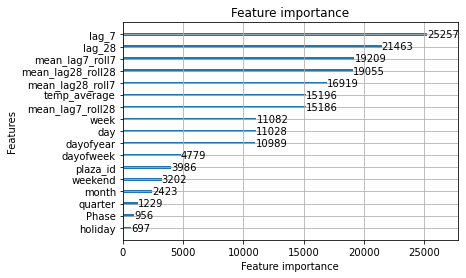

In [45]:
lgb.plot_importance(m_lgb)

In [46]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 8, 22) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

  7%|▋         | 35/499 [00:02<00:28, 16.21it/s]


end of loop


In [47]:
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-08-23', '2020-09-26'))][['datetime', 'plaza_id', 'value']]
# _lgbm_pred
_lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
_lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
test_set_pivot.columns = bridges

In [48]:
_lgbm_rmse = []
for i in bridges:
    _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))
_results_df['LGBM'] = _lgbm_rmse
display(_results_df.sum(axis=0))
_results_df

bridges         Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                                 68952.7
SARIMAX                                                   43468.5
FB_prophet_1                                              47697.9
LGBM                                                      44943.7
dtype: object

,bridges,dummy_MA7,SARIMAX,FB_prophet_1,LGBM
0,Brooklyn Battery,9689.766880,3800.422075,4146.735600,3909.244097
1,Cross Bay,3058.987092,3038.366098,2881.517478,3008.644669
2,Henry Hudson,7491.891404,4013.042613,3873.400612,3942.044990
3,Marine Parkway,4298.716057,4266.804149,4428.792730,3942.005070
4,Queens Midtown,9678.803759,3593.463138,9071.725197,4129.801764
5,Throgs Neck,7107.930655,7021.236084,5813.764461,7693.743703
6,Triboro,12989.973539,8760.379990,7645.789449,7657.774863
7,Verrazano,6814.856433,3236.013288,3338.660881,4430.386676
8,Whitestone,7821.773825,5738.769982,6497.563062,6230.082334


In [49]:
_results_df.sum(axis=0)

bridges         Brooklyn BatteryCross BayHenry HudsonMarine Pa...
dummy_MA7                                                 68952.7
SARIMAX                                                   43468.5
FB_prophet_1                                              47697.9
LGBM                                                      44943.7
dtype: object

# Best Model Forward: LGBM
LGBM performed the best out of the three. On the next notebook, I will refit the model off the entire dataset and predict up to March-31-2021. <br>
In addition, I'll change some of the phases on January-1-2021:
1. Phase -1: Coronavirus is over, return back to normal
2. Phase 4: Continue with Phase 4
3. Phase 1: Lockdown and reopen on February-01-2021